# Only SegDup Simulation Analysis

Comparing results between standard and self-mapped approaches.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch
from matplotlib import font_manager
from matplotlib.transforms import Bbox
from pypdf import PdfWriter
import json
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Set title
experiment_title = "Only segdup"
experiment_prefix = experiment_title.replace(" ", "_").lower()
figure_dir = f"/Users/stacy/Documents/Writing/spermSV/Supplement/Figures/nova/{experiment_prefix}"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)
individual_figure_dir = f"{figure_dir}/individual_plots"
if not os.path.exists(individual_figure_dir):
    os.makedirs(individual_figure_dir)
multiple_figure_dir = f"{figure_dir}/multiple_subplots"
if not os.path.exists(multiple_figure_dir):
    os.makedirs(multiple_figure_dir)

indiv_fig_prefix = f"{individual_figure_dir}/{experiment_prefix}"
multi_fig_prefix = f"{multiple_figure_dir}/{experiment_prefix}"
indiv_pdf_files = []
multi_pdf_files = []


SINGLE_COL_WIDTH = 3.5  # inches
DOUBLE_COL_WIDTH = 7.0  # inches
MAX_HEIGHT = 9.0  # typical max height for a full page

# Set consistent DPI for both display and saving
SAVE_DPI = 300  # publication quality
mpl.rcParams['figure.dpi'] = 150  # for display
mpl.rcParams['savefig.dpi'] = SAVE_DPI

# Set style
# sns.set_context("notebook", font_scale=1.2)
sns.set_style('whitegrid')
# we mostly want the border formatting, get rid of grid lines
mpl.rcParams['axes.grid'] = False

# save stock defaults for reference
default_font_family = plt.rcParams['font.family']
default_fonts = plt.rcParams['font.sans-serif'] 

# set default font 
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.sans-serif'] = prop.get_name()

# Load the JSON data
hg38_path = "/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups/only_segdup/nova_analysis_summary.json"
self_path = "/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups_self_map/only_segdup/nova_analysis_summary.json"

with open(hg38_path, 'r') as f:
    standard_json = json.load(f)

with open(self_path, 'r') as f:
    self_map_json = json.load(f)

# Load CSV data
standard_df = pd.read_csv('/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups/only_segdup/nova_analysis_summary.csv')
self_map_df = pd.read_csv('/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups_self_map/only_segdup/nova_analysis_summary.csv')

# Add experiment type column for combined analysis
standard_df['experiment'] = 'Standard'
self_map_df['experiment'] = 'Self-mapped'
combined_df = pd.concat([standard_df, self_map_df], ignore_index=True)

# Add insertion type f1 score
combined_df['f1_score'] = (2*(combined_df['precision'] * combined_df['recall'])) / (100*(combined_df['precision'] + combined_df['recall']))

# Load variants
standard_variants_df = pd.read_csv('/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups/only_segdup/nova_analyzed_variants.csv')
self_map_variants_df = pd.read_csv('/Users/stacy/Documents/GitHub/nova/experiments/alu_segdups_self_map/only_segdup/nova_analyzed_variants.csv')

# Add experiment type column for combined analysis
standard_variants_df['experiment'] = 'Standard'
self_map_variants_df['experiment'] = 'Self-mapped'
combined_variants_df = pd.concat([standard_variants_df, self_map_variants_df], ignore_index=True)
# Strip _MATERNAL and _PATERNAL suffixes from chrom column
combined_variants_df['chrom'] = combined_variants_df['chrom'].str.replace('_MATERNAL', '').str.replace('_PATERNAL', '')

# Define color palettes
standard_color = 'lightblue'
self_mapped_color = '#328ba8'

# Seaborn palette dictionary
exp_palette = {'Standard': standard_color, 'Self-mapped': self_mapped_color}


In [2]:
# for filter analysis
# Create dataframe of filter counts for all variants in experiments
standard_all_variant_filter_counts = pd.DataFrame({
    'filter': list(standard_json['summary']['all_vcf_filters']['total_by_filter'].keys()),
    'count': list(standard_json['summary']['all_vcf_filters']['total_by_filter'].values()),
    'experiment': 'Standard'
})

self_map_all_variant_filter_counts = pd.DataFrame({
    'filter': list(self_map_json['summary']['all_vcf_filters']['total_by_filter'].keys()),
    'count': list(self_map_json['summary']['all_vcf_filters']['total_by_filter'].values()),
    'experiment': 'Self-mapped'
})
overall_filter_counts_df = pd.concat([standard_all_variant_filter_counts, self_map_all_variant_filter_counts], ignore_index=True).sort_values(by='count', ascending=False)
overall_filter_counts_df

standard_tp_filter_counts = pd.DataFrame({
    'filter': list(standard_json['filter_breakdown']['true_positives_by_filter'].keys()),
    'count': list(standard_json['filter_breakdown']['true_positives_by_filter'].values()),
    'experiment': 'Standard'
})

self_map_tp_filter_counts = pd.DataFrame({
    'filter': list(self_map_json['filter_breakdown']['true_positives_by_filter'].keys()),
    'count': list(self_map_json['filter_breakdown']['true_positives_by_filter'].values()),
    'experiment': 'Self-mapped'
})

overall_tp_filter_counts_df = pd.concat([standard_tp_filter_counts, self_map_tp_filter_counts], ignore_index=True).sort_values(by='count', ascending=False)
overall_tp_filter_counts_df

standard_fp_filter_counts = pd.DataFrame({
    'filter': list(standard_json['filter_breakdown']['false_positives_by_filter'].keys()),
    'count': list(standard_json['filter_breakdown']['false_positives_by_filter'].values()),
    'experiment': 'Standard'
})

self_map_fp_filter_counts = pd.DataFrame({
    'filter': list(self_map_json['filter_breakdown']['false_positives_by_filter'].keys()),
    'count': list(self_map_json['filter_breakdown']['false_positives_by_filter'].values()),
    'experiment': 'Self-mapped'
})

overall_fp_filter_counts_df = pd.concat([standard_fp_filter_counts, self_map_fp_filter_counts], ignore_index=True).sort_values(by='count', ascending=False)

false_positives_by_chrom = combined_variants_df.query("identity == 'false_positive'")[['experiment','chrom', 'identity']].value_counts().to_frame().reset_index()
true_positives_by_chrom = combined_variants_df.query("identity == 'true_positive'")[['experiment','chrom', 'identity']].value_counts().to_frame().reset_index()
recall_by_chrom = combined_variants_df.query("identity == 'recalled'")[['experiment','chrom', 'identity']].value_counts().to_frame().reset_index()
precision_by_chrom = combined_variants_df.query("identity == 'precision'")[['experiment','chrom', 'identity']].value_counts().to_frame().reset_index()

# Individual Plots

NameError: name 'pdf_files' is not defined

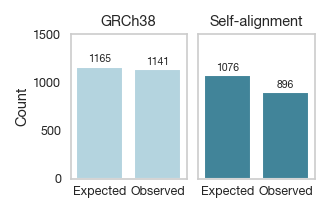

In [ ]:
# Create bar plot
plot_expected_observed = pd.melt(
    combined_df[['experiment', 'expected_variants_with_nova', 'total_variants_with_nova']], 
    id_vars=['experiment'],
    value_vars=['expected_variants_with_nova', 'total_variants_with_nova'],
    var_name='metric',
    value_name='count'
).replace({
    'expected_variants_with_nova': 'Expected',
    'total_variants_with_nova': 'Observed'
}).drop_duplicates()

fig, ax = plt.subplots(ncols=2, figsize = (SINGLE_COL_WIDTH*0.6, 1.25), gridspec_kw={'wspace': 0.1}, sharey = True)

sns.barplot(plot_expected_observed.query("experiment == 'Standard'"), x='metric', y='count', hue='metric', errorbar = None,
            ax=ax[0], legend = False, palette = {'Expected': exp_palette['Standard'], 'Observed': exp_palette['Standard']})
ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel('GRCh38', fontsize=7)
ax[0].tick_params(axis='x', length=0, labelsize=6)
ax[0].set_xticklabels(ax[0].get_xticklabels())
ax[0].tick_params(axis='y', pad = 1, labelsize=6)
ax[0].set_ylabel('Count', fontsize=7, labelpad = 2)
ax[0].set_ylim(0, 1500)

sns.barplot(plot_expected_observed.query("experiment == 'Self-mapped'"), x='metric', y='count', hue='metric', errorbar = None,
            ax=ax[1], legend = False, palette = {'Expected': exp_palette['Self-mapped'], 'Observed': exp_palette['Self-mapped']})
ax[1].xaxis.set_label_position('top')
ax[1].set_xlabel('Self-alignment', fontsize=7)
ax[1].tick_params(axis='x', length=0, labelsize=6)
ax[1].set_xticklabels(ax[1].get_xticklabels())
ax[1].tick_params(axis='y', length = 2, labelsize=6)
ax[1].set_ylabel('')

# Add count annotations on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f', padding=1, fontsize=5)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.0f', padding=1, fontsize=5)

plt.savefig(f"{indiv_fig_prefix}_expected_observed_variant_counts.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_expected_observed_variant_counts.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True, bbox_inches='tight')

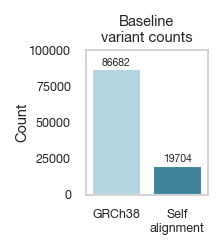

In [ ]:
# Create bar plot
fig, ax = plt.subplots(figsize=(SINGLE_COL_WIDTH*0.3, 1.25))
sns.barplot(data=combined_df[['experiment', 'total_variants_in_vcf']].groupby('experiment').median().reset_index(), 
x='experiment', y='total_variants_in_vcf', palette=exp_palette, ax=ax,
order = ['Standard', 'Self-mapped'])

# Add count annotations on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=1, fontsize=5)

# ax.set_yscale('log')
# ax.set_ylim(top=10**6)
ax.set_xticks(ticks=ax.get_xticks(), labels = ['GRCh38', 'Self\nalignment'], fontsize=6)
ax.set_yticks(ticks=[0, 25000, 50000, 75000, 100000], labels = [0, 25000, 50000, 75000, 100000],fontsize=6)
ax.xaxis.set_label_position('top')
ax.set_xlabel('Baseline\nvariant counts', size = 7)
ax.set_ylabel('Count', fontsize=7, labelpad = 0)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))

plt.savefig(f"{indiv_fig_prefix}_baseline_variant_counts.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_baseline_variant_counts.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True, bbox_inches='tight')

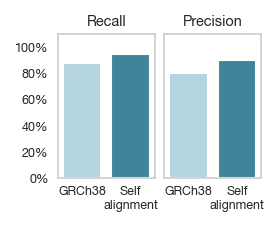

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize = (SINGLE_COL_WIDTH*0.5, 1.25), gridspec_kw={'wspace': 0.1}, sharey = True)

sns.barplot(combined_df, x='experiment', y='overall_recall', hue='experiment', errorbar = None,
            palette=exp_palette, ax=ax[0], legend = False)
ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel('Recall', fontsize=7)
ax[0].tick_params(axis='x', length=0, labelsize=6)
ax[0].set_xticks(ticks=ax[0].get_xticks(), labels=['GRCh38', 'Self\nalignment'])
ax[0].tick_params(axis='y', pad = 1, labelsize=6)
ax[0].set_ylabel('')
ax[0].set_ylim(0, 110)
ax[0].set_yticks([0, 20, 40, 60, 80, 100])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(combined_df, x='experiment', y='overall_precision', hue='experiment', errorbar = None,
            palette=exp_palette, ax=ax[1], legend = False)
ax[1].xaxis.set_label_position('top')
ax[1].set_xlabel('Precision', fontsize=7)
ax[1].tick_params(axis='x', length=0, labelsize=6)
ax[1].set_xticks(ticks=ax[1].get_xticks(), labels=['GRCh38', 'Self\nalignment'])
ax[1].tick_params(axis='y', length = 2, labelsize=6)
ax[1].set_ylabel('')
ax[1].set_ylim(0, 110)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig(f"{indiv_fig_prefix}_recall_precision.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_recall_precision.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path,
            transparent = True,
            bbox_inches = 'tight')

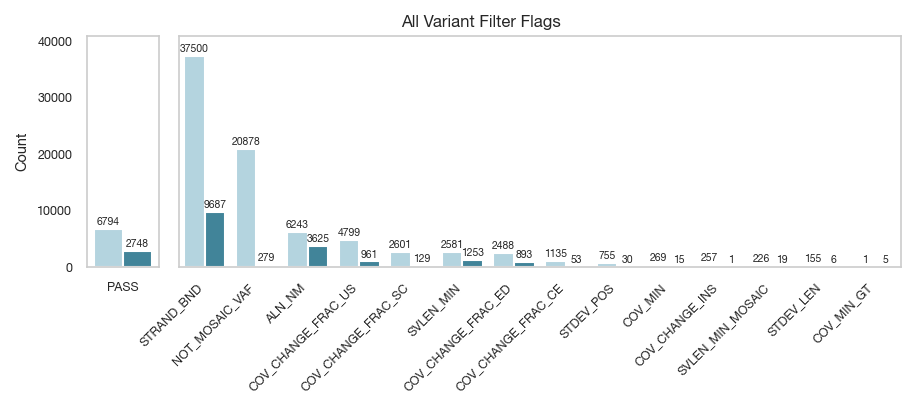

In [ ]:
# Create bar plot
fig, ax = plt.subplots(ncols = 2, figsize=(DOUBLE_COL_WIDTH, 2), sharey = True, gridspec_kw={'width_ratios': [1, 10], 'wspace': 0.05})

sns.barplot(ax = ax[0], data=overall_filter_counts_df.query("filter == 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette, legend = False)
sns.barplot(ax = ax[1], data=overall_filter_counts_df.query("filter != 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette,
legend = False)

ax[0].set_xticks(ticks=ax[0].get_xticks(), labels=ax[0].get_xticklabels(), fontsize=6)
ax[0].set_yticks(ticks=ax[0].get_yticks(), labels=ax[0].get_yticks(), fontsize=6)
ax[0].set_xlabel('', size = 7)
ax[0].set_ylabel('Count', size = 7)
ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
ax[0].set_ylim(0, 41000)

ax[1].set_xticks(ticks=ax[1].get_xticks(), labels=ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax[1].set_xlabel('', size = 7)
ax[1].set_ylabel('Count', size = 7)
ax[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
ax[1].set_ylim(0, 41000)

# Add count annotations on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f', padding=1, fontsize=5)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.0f', padding=1, fontsize=5)

plt.suptitle('All Variant Filter Flags', size = 8, y = 0.95)

plt.savefig(f"{indiv_fig_prefix}_all_variant_filter_flags.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_all_variant_filter_flags.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight')

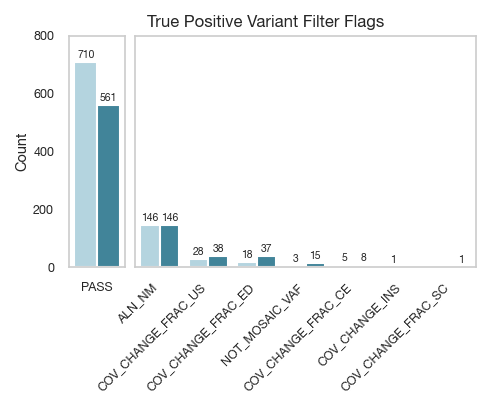

In [ ]:
# Create bar plot
fig, ax = plt.subplots(ncols = 2, figsize=(SINGLE_COL_WIDTH, 2), sharey = True, gridspec_kw={'width_ratios': [1, 6], 'wspace': 0.05})

sns.barplot(ax = ax[0], data=overall_tp_filter_counts_df.query("filter == 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette, legend = False)
sns.barplot(ax = ax[1], data=overall_tp_filter_counts_df.query("filter != 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette,
legend = False)

ax[0].set_ylim(0, 800)
ax[0].set_xticks(ticks=ax[0].get_xticks(), labels=ax[0].get_xticklabels(), fontsize=6)
ax[0].set_yticks(ticks=ax[0].get_yticks(), labels=ax[0].get_yticks(), fontsize=6)
ax[0].set_xlabel('', size = 7)
ax[0].set_ylabel('Count', size = 7, labelpad = 2)
ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))

ax[1].set_ylim(0, 800)
ax[1].set_xticks(ticks=ax[1].get_xticks(), labels=ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax[1].set_yticks(ticks=ax[1].get_yticks(), labels=ax[1].get_yticks(), fontsize=6)
ax[1].set_xlabel('', size = 7)
ax[1].set_ylabel('Count', size = 7)
ax[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))


# Add count annotations on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f', padding=1, fontsize=5)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.0f', padding=1, fontsize=5)

plt.suptitle('True Positive Variant Filter Flags', size = 8, y = 0.95)

plt.savefig(f"{indiv_fig_prefix}_tp_variant_filter_flags.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_tp_variant_filter_flags.pdf"
indiv_pdf_files.append(pdf_path)  
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight')

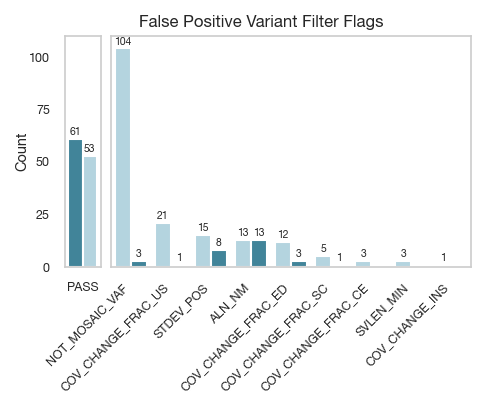

In [ ]:
# Create bar plot
fig, ax = plt.subplots(ncols = 2, figsize=(SINGLE_COL_WIDTH, 2), sharey = True, gridspec_kw={'width_ratios': [1, 10], 'wspace': 0.05})

sns.barplot(ax = ax[0], data=overall_fp_filter_counts_df.query("filter == 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette, legend = False)
sns.barplot(ax = ax[1], data=overall_fp_filter_counts_df.query("filter != 'PASS'"), 
x='filter', y='count', hue='experiment', palette=exp_palette,
legend = False)

ax[0].set_xticks(ticks=ax[0].get_xticks(), labels=ax[0].get_xticklabels(), fontsize=6)
ax[0].set_yticks(ticks=ax[0].get_yticks(), labels=ax[0].get_yticks(), fontsize=6)
ax[0].set_xlabel('', size = 7)
ax[0].set_ylabel('Count', size = 7, labelpad = 0)
ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
ax[0].set_ylim(0, 110)
ax[1].set_xticks(ticks=ax[1].get_xticks(), labels=ax[1].get_xticklabels(), rotation=45, ha='right', fontsize=6)
ax[1].set_yticks(ticks=ax[1].get_yticks(), labels=ax[1].get_yticks(), fontsize=6)
ax[1].set_xlabel('', size = 7)
ax[1].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
ax[1].set_ylim(0, 110)

# Add count annotations on top of bars
for container in ax[0].containers:
    ax[0].bar_label(container, fmt='%.0f', padding=1, fontsize=5)
for container in ax[1].containers:
    ax[1].bar_label(container, fmt='%.0f', padding=1, fontsize=5)

plt.suptitle('False Positive Variant Filter Flags', size = 8, y = 0.95)
plt.savefig(f"{indiv_fig_prefix}_fp_variant_filter_flags.png",  
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_fp_variant_filter_flags.pdf"
indiv_pdf_files.append(pdf_path)  
plt.savefig(pdf_path,  
            transparent = True,
            bbox_inches = 'tight')

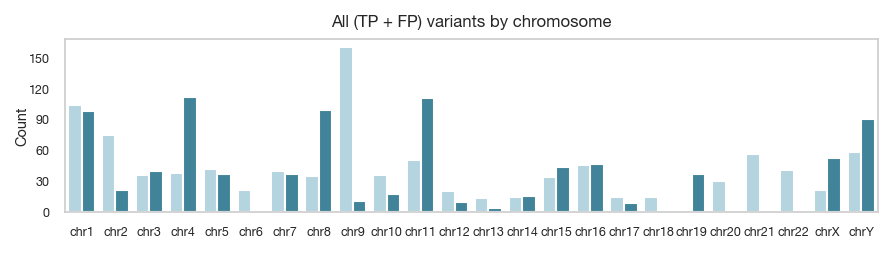

In [ ]:
fig, ax = plt.subplots(figsize = (DOUBLE_COL_WIDTH, 1.5))

sns.barplot(combined_variants_df[['chrom', 'experiment']].value_counts().to_frame().reset_index(),
            x = 'chrom',
            y = 'count',
            hue = 'experiment',
            order = [f"chr{i}" for i in range(1, 23)] + ['chrX', 'chrY'],
            palette = exp_palette,
            ax = ax, 
            legend = False)
ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), fontsize=6)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=7, labelpad = 0)
ax.set_title('All (TP + FP) variants by chromosome', fontsize=8)
ax.set_yticks(ticks=np.arange(0, 151, 30), labels=np.arange(0, 151, 30), fontsize=6)

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))

plt.savefig(f"{indiv_fig_prefix}_all_variants_by_chromosome.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_all_variants_by_chromosome.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight')

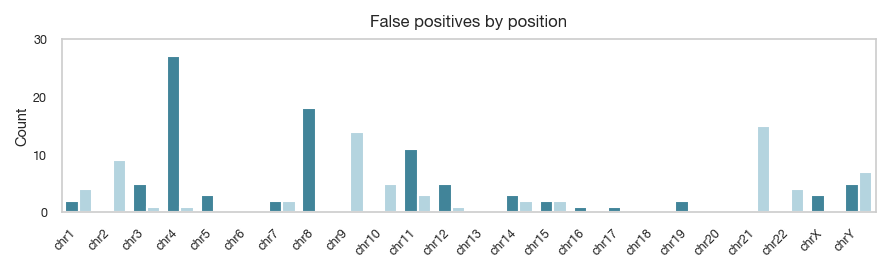

In [ ]:
fig, ax = plt.subplots(figsize = (DOUBLE_COL_WIDTH, 1.5))

sns.barplot(data=false_positives_by_chrom,
            x = 'chrom',
            y = 'count', 
            hue = 'experiment',
            palette = exp_palette,
            order = [f"chr{i}" for i in range(1, 23)] + ['chrX', 'chrY'],
            ax = ax, 
            legend = False)

ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), fontsize=6, rotation=45, ha='right')
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticks(), fontsize=6)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=7, labelpad = 2)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))

ax.set_title('False positives by position', size = 8)

plt.savefig(f"{indiv_fig_prefix}_false_positives_by_chromosome.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_false_positives_by_chromosome.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight')

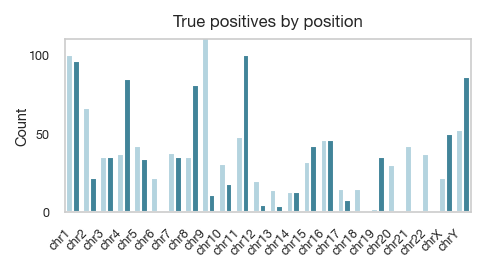

In [ ]:
fig, ax = plt.subplots(figsize = (SINGLE_COL_WIDTH, 1.5))

sns.barplot(data=true_positives_by_chrom,
            x = 'chrom',
            y = 'count', 
            hue = 'experiment',
            palette = exp_palette,
            order = [f"chr{i}" for i in range(1, 23)] + ['chrX', 'chrY'],
            ax = ax, 
            legend = False)

ax.set_xticks(ticks=ax.get_xticks(), labels=ax.get_xticklabels(), fontsize=6, rotation=45, ha='right')
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticks(), fontsize=6)
ax.set_xlabel('')
ax.set_ylabel('Count', fontsize=7, labelpad = 0)
ax.set_ylim(0, 110)
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: f'{int(x)}'))

ax.set_title('True positives by position', size = 8)

plt.savefig(f"{indiv_fig_prefix}_true_positives_by_chromosome.png", 
            transparent = True, dpi=300, bbox_inches='tight')
pdf_path = f"{indiv_fig_prefix}_true_positives_by_chromosome.pdf"
indiv_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight')

## 1. Recall and Precision

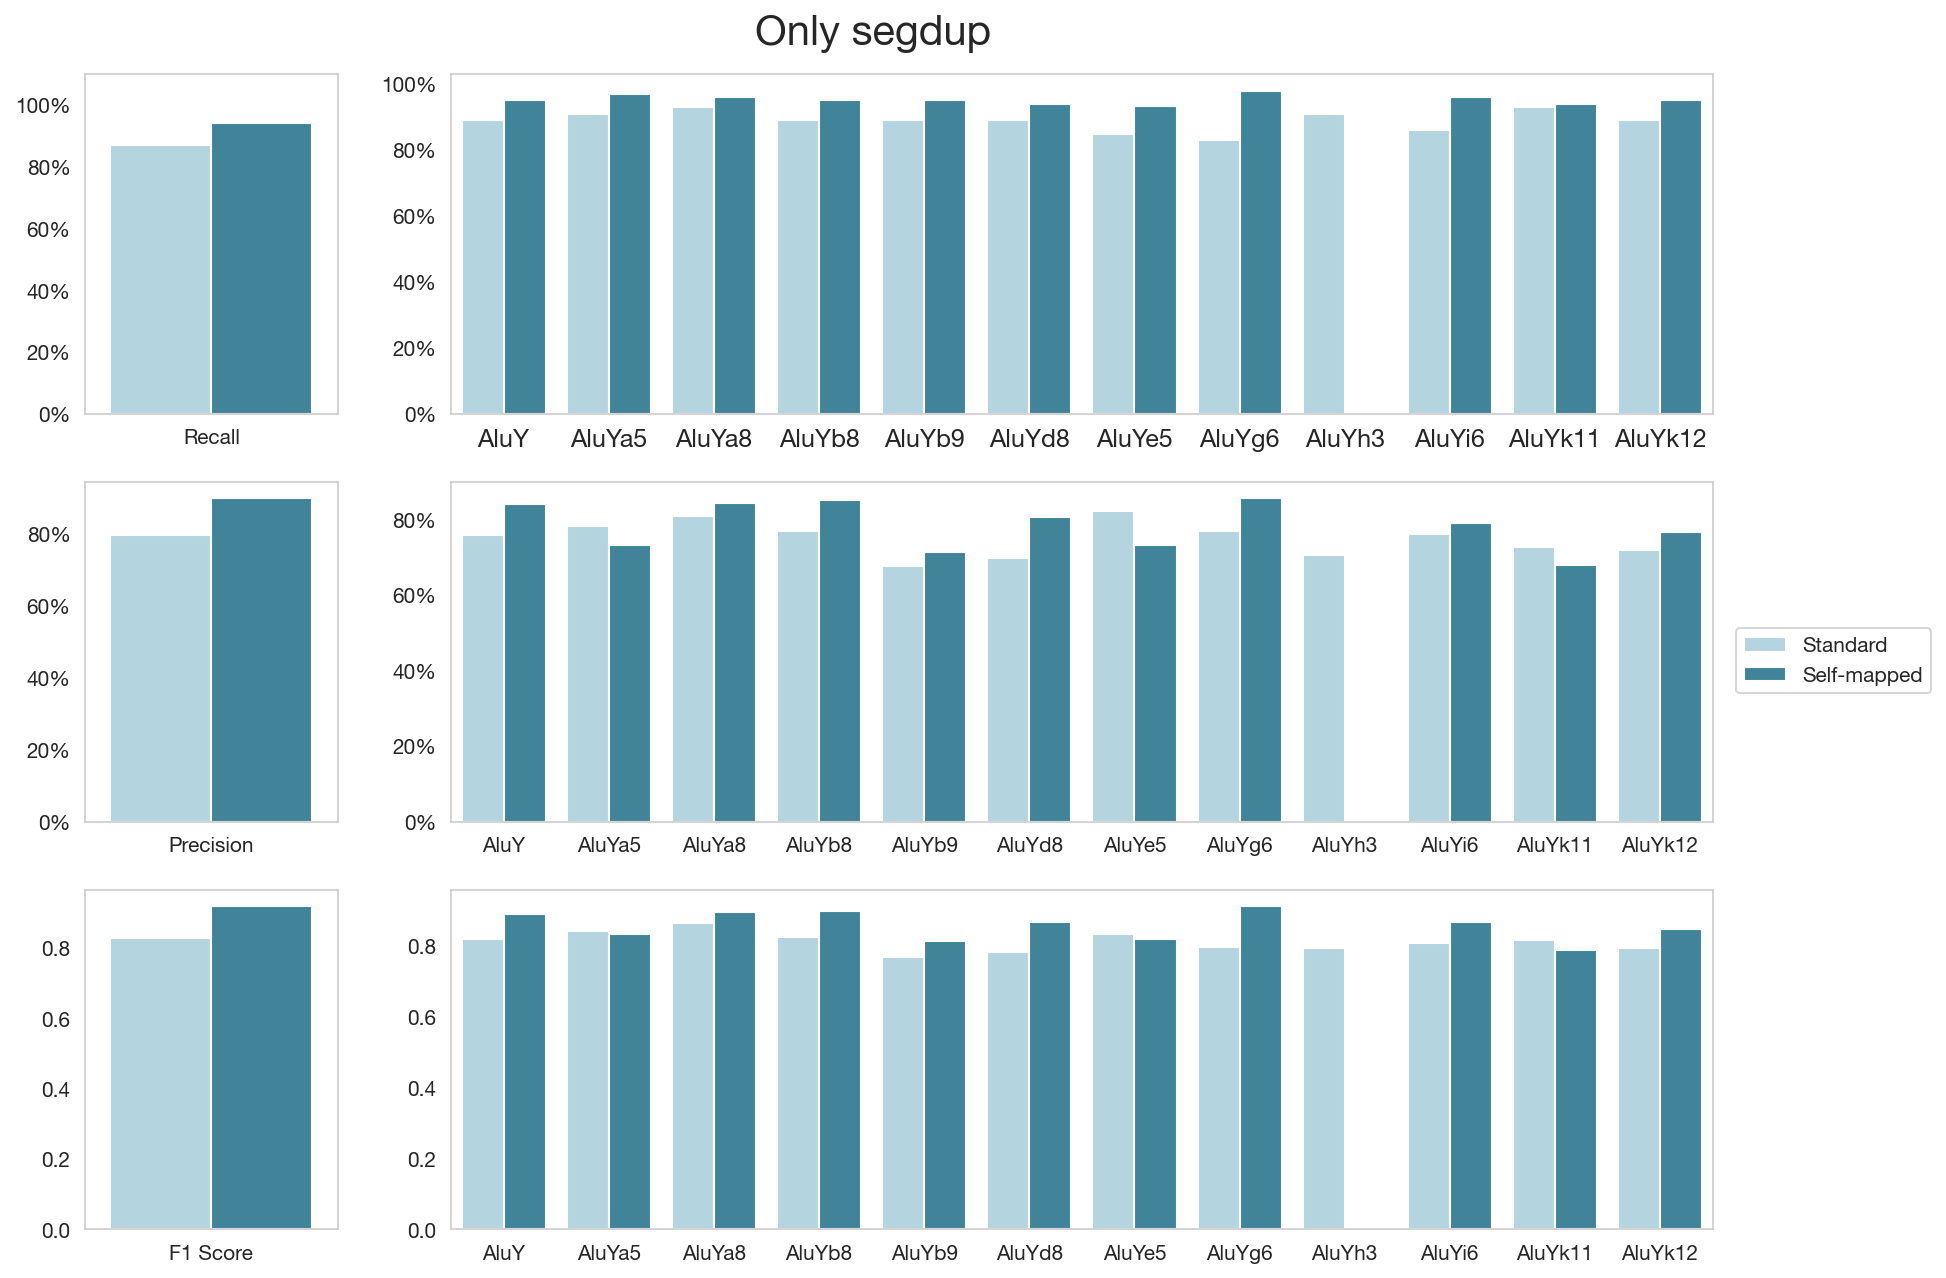

In [ ]:
overall_melted_df = combined_df.melt(
    id_vars=['experiment'],
    value_vars=['overall_recall', 'overall_precision', 'overall_f1_score'],
    var_name='metric',
    value_name='percentage').drop_duplicates()

instype_melted_df = combined_df.melt(
    id_vars=['insertion_type', 'experiment'],
    value_vars=['recall', 'precision', 'f1_score'],
    var_name='metric',
    value_name='percentage')

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14,10), gridspec_kw={'width_ratios': [1, 5], 'wspace': 0.15})

# # Set tick label size to 12 for all subplots
# for row in ax:
#     for subplot in row:
#         subplot.tick_params(axis='both', labelsize=12)

sns.barplot(overall_melted_df.query('metric == "overall_recall"'), x='metric', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[0, 0], legend = False)
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('')
ax[0,0].set_xticklabels(["Recall"])
ax[0,0].set_ylim(0, 110)
ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(overall_melted_df.query('metric == "overall_precision"'), x='metric', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[1, 0], legend = False)
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('')
ax[1,0].set_xticklabels(["Precision"]) 
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(overall_melted_df.query('metric == "overall_f1_score"'), x='metric', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[2, 0], legend = False)
ax[2,0].set_xlabel('')
ax[2,0].set_ylabel('')
ax[2,0].set_xticklabels(["F1 Score"])

sns.barplot(instype_melted_df.query('metric == "recall"'), x='insertion_type', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[0, 1], legend = False)
ax[0,1].tick_params(axis='x', labelsize=12)
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels())
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(instype_melted_df.query('metric == "precision"'), x='insertion_type', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[1, 1])
ax[1,1].tick_params(axis='x')
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels())
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')
ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter())
ax[1,1].legend(loc = 'upper left', bbox_to_anchor = (1.01, 0.6))

sns.barplot(instype_melted_df.query('metric == "f1_score"'), x='insertion_type', y='percentage', hue='experiment',
            palette=exp_palette, ax=ax[2, 1], legend = False)
ax[2,1].tick_params(axis='x')
ax[2,1].set_xticklabels(ax[2,1].get_xticklabels())
ax[2,1].set_xlabel('')
ax[2,1].set_ylabel('')

plt.suptitle(f"{experiment_title}", y = 0.92, fontsize = 20)

plt.savefig(f"{multi_fig_prefix}_performance_metrics.png", 
            bbox_inches=Bbox([[0,0], [15,10]]),
            transparent = True,
            dpi=300)

pdf_path = f"{multi_fig_prefix}_performance_metrics.pdf"
multi_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            bbox_inches=Bbox([[1,0.5], [14.5,9.5]]),
            transparent = True,
            format = 'pdf')

## 2. False Positive Analysis

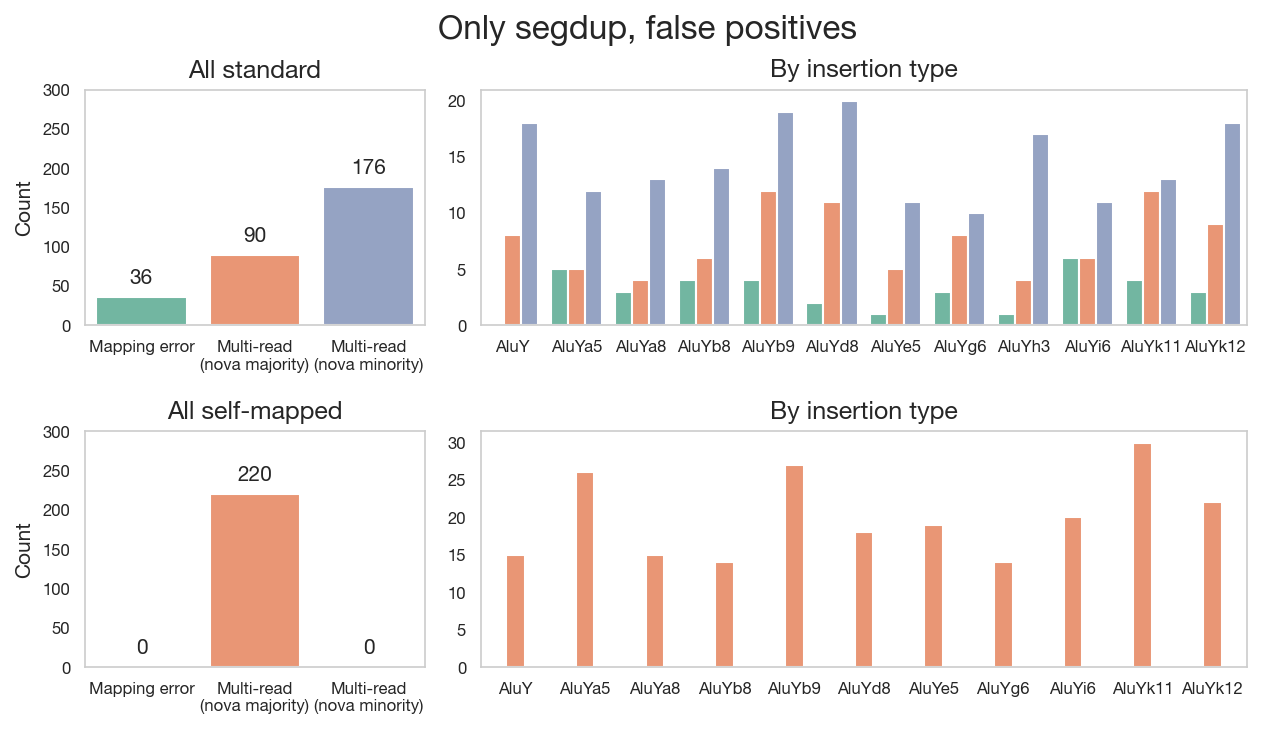

In [ ]:
# Prepare false positive data
fp_cols = ['fp_mapping_errors', 'fp_multi_read_majority', 'fp_multi_read_minority']
fp_melted = combined_df.melt(
    id_vars=['insertion_type', 'experiment'],
    value_vars=fp_cols,
    var_name='fp_type',
    value_name='count'
)

# Clean up labels
fp_melted['fp_type'] = fp_melted['fp_type'].map({
    'fp_mapping_errors': 'Mapping error',
    'fp_multi_read_majority': 'Multi-read\n(nova majority)',
    'fp_multi_read_minority': 'Multi-read\n(nova minority)'
})

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 2.25], 'wspace': 0.1, 'hspace': 0.45})

for row in ax:
    for subplot in row:
        subplot.tick_params(axis='both', labelsize=8)

g1 = sns.barplot(fp_melted.query("experiment == 'Standard'").groupby('fp_type').agg({'count': 'sum'}), x='fp_type', y='count', hue='fp_type',
            palette='Set2', ax=ax[0, 0], errorbar = None, legend = False)
ax[0,0].set_title('All standard')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Count')    
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels())
ax[0,0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))
ax[0,0].set_ylim(0, 300)
# Add count annotations
for p in g1.patches:
    g1.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 10,
                fontweight = '600')

g2 = sns.barplot(fp_melted.query("experiment == 'Self-mapped'").groupby('fp_type').agg({'count': 'sum'}), x='fp_type', y='count', hue='fp_type',
            palette='Set2', ax=ax[1, 0], errorbar = None, legend = False)
ax[1,0].set_title('All self-mapped')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Count')    
ax[1,0].set_xticklabels(ax[1,0].get_xticklabels())
ax[1,0].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))
ax[1,0].set_ylim(0, 300)
# Add count annotations
for p in g2.patches:
    g2.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 10,
                fontweight = '600')

sns.barplot(fp_melted.query("experiment == 'Standard'"), x='insertion_type', y='count', hue='fp_type',
            palette='Set2', ax=ax[0, 1], legend = False)
ax[0,1].set_xlabel('')    
ax[0,1].set_ylabel('')    
ax[0,1].set_xticklabels(ax[0,1].get_xticklabels())
ax[0,1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))
# ax[0,1].legend(loc = 'upper right', bbox_to_anchor = (1.35, 0.1))
# ax[0,1].set_ylim(0, 13)
# ax[0,1].set_yticks(range(0, 14, 4))
# ax[0,1].yaxis.set_tick_params(labelcolor='none')
ax[0,1].set_title('By insertion type')

sns.barplot(fp_melted.query("experiment == 'Self-mapped'"), x='insertion_type', y='count', hue='fp_type',
            palette='Set2', ax=ax[1, 1], legend = False)
ax[1,1].set_xlabel('')    
ax[1,1].set_ylabel('')    
ax[1,1].set_xticklabels(ax[1,1].get_xticklabels())
ax[1,1].yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))
# ax[1,1].set_ylim(0, 13)
# ax[1,1].set_yticks(range(0, 14, 4))
# ax[1,1].yaxis.set_tick_params(labelcolor='none')
ax[1,1].set_title('By insertion type')

plt.suptitle(f"{experiment_title}, false positives", fontsize = 16)

plt.savefig(f"{multi_fig_prefix}_false_positives.png", 
            dpi=300,
            transparent = True)

pdf_path = f"{multi_fig_prefix}_false_positives.pdf"
multi_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches=Bbox([[0.6,0], [9.25,5]]),
            format = 'pdf')

## 3. True Positive Analysis

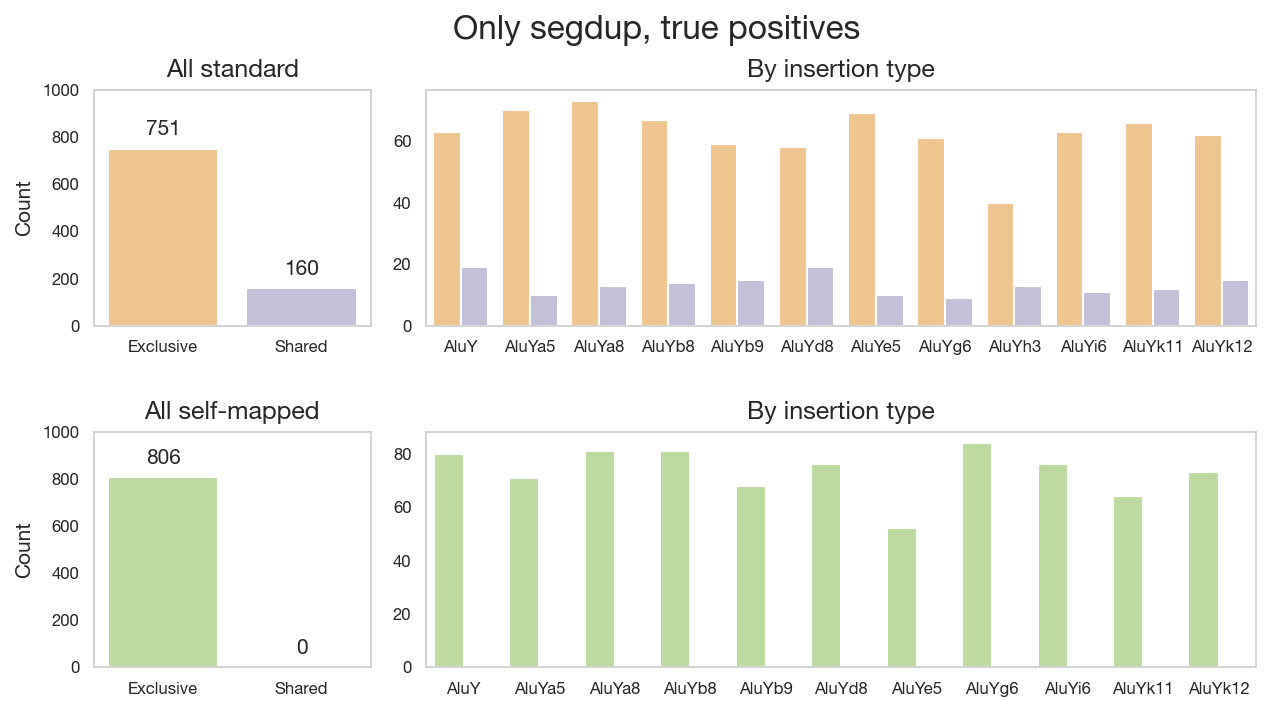

In [ ]:
# Prepare TP data
tp_cols = ['tp_exclusive', 'tp_shared']
tp_melted = combined_df.melt(
    id_vars=['insertion_type', 'experiment'],
    value_vars=tp_cols,
    var_name='tp_type',
    value_name='count'
)

tp_melted['tp_type'] = tp_melted['tp_type'].map({
    'tp_exclusive': 'Exclusive',
    'tp_shared': 'Shared'
})


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5), gridspec_kw={'width_ratios': [1, 3], 'wspace': 0.1, 'hspace': 0.45})

for row in ax:
    for subplot in row:
        subplot.tick_params(axis='both', labelsize=8)

g1 = sns.barplot(data=tp_melted.query('experiment == "Standard"').groupby('tp_type').agg({'count': 'sum'}), x='tp_type', y='count',
            hue='tp_type', palette='PuOr', ax=ax[0,0], errorbar = None, legend = False)
ax[0,0].set_title('All standard')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Count')
ax[0,0].set_ylim(0, 1000)
# ax[0,0].set_yticks(range(0, 111, 20))

for p in g1.patches:
    g1.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 10,
                fontweight = '600')

g2 = sns.barplot(data=tp_melted.query('experiment == "Self-mapped"').groupby('tp_type').agg({'count': 'sum'}), x='tp_type', y='count',
            hue='tp_type', palette='YlGn', ax=ax[1,0], errorbar = None, legend = False)
ax[1,0].set_title('All self-mapped')
ax[1,0].set_xlabel('')
ax[1,0].set_ylabel('Count')
ax[1,0].set_ylim(0, 1000)

for p in g2.patches:
    g2.annotate(format(int(p.get_height()), 'd'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', 
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize = 10,
                fontweight = '600')

sns.barplot(data=tp_melted.query('experiment == "Standard"'), x='insertion_type', y='count',
            hue='tp_type', palette='PuOr', ax=ax[0,1], legend = False)
ax[0,1].set_title('By insertion type')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

sns.barplot(data=tp_melted.query('experiment == "Self-mapped"'), x='insertion_type', y='count',
            hue='tp_type', palette='YlGn', ax=ax[1,1], legend = False)
ax[1,1].set_title('By insertion type')
ax[1,1].set_xlabel('')
ax[1,1].set_ylabel('')

plt.suptitle(f"{experiment_title}, true positives", fontsize = 16)

plt.savefig(f"{multi_fig_prefix}_true_positives.png", 
            dpi=300,
            transparent = True)

pdf_path = f"{multi_fig_prefix}_true_positives.pdf"
multi_pdf_files.append(pdf_path)
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches=Bbox([[0.6,0], [9.25,5]]),
            format = 'pdf')

## 4. Mapping Quality Analysis

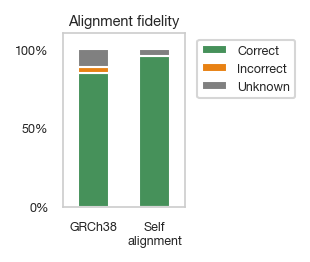

In [ ]:
# Prepare mapping data
mapping_cols = ['mapping_unknown', 'mapping_correct', 'mapping_incorrect']
mapping_melted = combined_df.melt(
    id_vars=['insertion_type', 'experiment'],
    value_vars=mapping_cols,
    var_name='mapping_type',
    value_name='count'
)

mapping_melted['mapping_type'] = mapping_melted['mapping_type'].map({
    'mapping_unknown': 'Unknown',
    'mapping_correct': 'Correct',
    'mapping_incorrect': 'Incorrect'
})

# Create percentage stacked bar
mapping_pivot = mapping_melted.pivot_table(
    index='experiment',
    columns='mapping_type',
    values='count',
    aggfunc='mean'
)
mapping_pivot = mapping_pivot.reindex(['Standard', 'Self-mapped'])


mapping_pivot_pct = mapping_pivot.div(mapping_pivot.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize = (SINGLE_COL_WIDTH*0.3, 1.5))

b = mapping_pivot_pct.plot(kind='bar', stacked=True, color=['#46915a', '#e88113', 'gray'], ax = ax)
ax.set_xticks(ticks=ax.get_xticks(), labels = ['GRCh38', 'Self\nalignment'], rotation = 0, fontsize = 6)
ax.set_yticks(ticks = ax.get_yticks(), labels = ax.get_yticks(), fontsize = 6)
ax.set_xlabel('Alignment fidelity', fontsize = 7)
ax.xaxis.set_label_position('top')
ax.set_ylabel('')
ax.set_ylim(0, 110)
b.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(title='', bbox_to_anchor=(1.05, 1), fontsize = 6)
# plt.suptitle(f"{experiment_title}", fontsize = 20)

plt.tight_layout()

plt.savefig(f"{indiv_fig_prefix}_alignment_fidelity.png", 
            transparent = True,
            bbox_inches = 'tight',
            dpi=300)

pdf_path = f"{indiv_fig_prefix}_alignment_fidelity.pdf"
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight',
            format = 'pdf')

# 5. SVTYPE categorization (indiv)

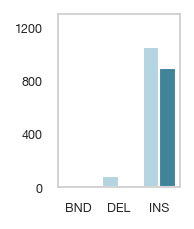

In [ ]:
# Create lists for each column
svtypes = []
experiments = []
counts = []

# Add standard data
for svtype, count in standard_json['variant_characteristics']['by_svtype'].items():
    svtypes.append(svtype)
    experiments.append('Standard')
    counts.append(count)

# Add self-mapped data  
for svtype, count in self_map_json['variant_characteristics']['by_svtype'].items():
    svtypes.append(svtype)
    experiments.append('Self-mapped')
    counts.append(count)

# Create dataframe
df = pd.DataFrame({
    'svtype': svtypes,
    'experiment': experiments, 
    'count': counts
})
df['percentage'] = df.groupby('experiment')['count'].transform(lambda x: x / x.sum())*100

fig, ax = plt.subplots(figsize = (SINGLE_COL_WIDTH*0.3, 1.5))
sns.barplot(x = 'svtype', y = 'count', data = df, hue = 'experiment', palette = exp_palette, ax = ax, legend = False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 6)
ax.set_ylim(0, 1300)
ax.set_yticks(ticks = np.arange(0, 1251, 400), labels = np.arange(0, 1251, 400), fontsize = 6)
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))

# Add count annotations on top of bars
# for container in ax.containers:
#     ax.bar_label(container, fmt='%.0f', padding=1, fontsize=5)

plt.savefig(f"{indiv_fig_prefix}_svtype_distribution.png", 
            transparent = True,
            bbox_inches = 'tight',
            dpi=300)

pdf_path = f"{indiv_fig_prefix}_svtype_distribution.pdf"
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight',
            format = 'pdf')


# 6. Read Reuse Analysis (indiv)

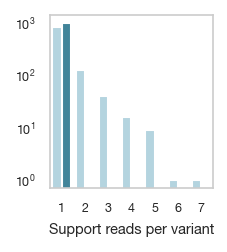

In [ ]:
# Get distributions
std_dist = standard_json['nova_read_reuse']['usage_distribution']
self_dist = self_map_json['nova_read_reuse']['usage_distribution']

# Create lists for dataframe
experiments = []
usage_distributions = []
counts = []

# Add standard data
for usage, count in std_dist.items():
    experiments.append('Standard')
    usage_distributions.append(int(usage))
    counts.append(count)

# Add self-mapped data
for usage, count in self_dist.items():
    experiments.append('Self-mapped')
    usage_distributions.append(int(usage))
    counts.append(count)

# Create dataframe
df = pd.DataFrame({
    'experiment': experiments,
    'usage_distribution': usage_distributions,
    'count': counts
})
df['percentage'] = df.groupby('experiment')['count'].transform(lambda x: x / x.sum())*100

fig, ax = plt.subplots(figsize = (SINGLE_COL_WIDTH*0.4, 1.5))

sns.barplot(x = 'usage_distribution', y = 'count', data = df, hue = 'experiment', palette = exp_palette, ax = ax, legend = False)
ax.set_ylabel('')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 6)
# ax.set_ylim(0, 1300)
ax.set_yticks(ticks = ax.get_yticks(), labels = ax.get_yticks(), fontsize = 6)
ax.set_yscale('log')
# ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, p: int(x)))
# ax.xaxis.set_label_position('top')
ax.set_xlabel('Support reads per variant', size = 7)


plt.savefig(f"{indiv_fig_prefix}_read_reuse.png", 
            transparent = True,
            bbox_inches = 'tight',
            dpi=300)

pdf_path = f"{indiv_fig_prefix}_read_reuse.pdf"
plt.savefig(pdf_path, 
            transparent = True,
            bbox_inches = 'tight',
            format = 'pdf')

# 7. Merge PDFs

In [ ]:
merged_indiv_pdf = f"{figure_dir}/{experiment_prefix}_indiv_figures.pdf"

writer = PdfWriter()
for pdf_file in indiv_pdf_files:
    writer.append(pdf_file)

writer.write(merged_indiv_pdf)
writer.close()

print(f"Merged individual PDF saved to {merged_indiv_pdf}")


merged_multi_pdf = f"{figure_dir}/{experiment_prefix}_multi_figures.pdf"

writer = PdfWriter()
for pdf_file in multi_pdf_files:
    writer.append(pdf_file)

writer.write(merged_multi_pdf)
writer.close()

print(f"Merged multi-subplot PDF saved to {merged_multi_pdf}")

Merged PDF saved to /Users/stacy/Documents/Writing/spermSV/Supplement/Figures/nova/only_segdup/only_segdup_multi_figures.pdf
